In [71]:
# preprocessing the raw document
# procedure based on: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/lda_training_tips.ipynb
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.corpora import Dictionary

# dealing w the error: "Resource 'corpora/wordnet.zip/wordnet/' not found"
#import nltk
#nltk.download()

def preprocess(docs,no_below=20,no_above=0.7):
    # input is a an array of docs; each is one string
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]   

    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    
    # Delete words based on their frequency in the whole corps
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)
    set_trace()
    # Filter out words that occur less than 20 documents, or more than 70% of the documents.
    dictionary.filter_extremes(no_below, no_above)
    
    # According to the filtered dictionary, reconstruct the corpus
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    return corpus, dictionary
    # TODO: linebreaks should be recovered into single word? search for solution first


In [74]:
# text preprocessing
import os
import codecs

from IPython.core.debugger import set_trace
datadir = "smallersamp/"
dirs = [name for name in os.listdir(datadir) if os.path.isdir(datadir+name)] # docs within each time slice are in one folder
ndocs = []
docs = []
for kdir in dirs:
    #iterate over all docs in each directory
    for dname in os.listdir(datadir+kdir):
        with codecs.open(datadir+kdir+'/'+dname, "r",encoding='utf-8', errors='ignore') as fin:
#        with open(datadir+kdir+'/'+dname, 'r') as fin:
            docs.append(fin.read()) # a string containing all texts
    ndocs.append(len(os.listdir(datadir+kdir)))
corpus, dictionary = preprocess(docs,no_below=3,no_above=0.4)

> <ipython-input-71-c39c7fe34a8f>(32)preprocess()
     30     set_trace()
     31     # Filter out words that occur less than 20 documents, or more than 70% of the documents.
---> 32     dictionary.filter_extremes(no_below, no_above)
     33 
     34     # According to the filtered dictionary, reconstruct the corpus

ipdb> c


In [75]:
[dictionary[k] for k in range(5)]

['love', 'fact', 'earlier', 'figure', 'added']

In [76]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print('Number of doc in each time slice:'+str(ndocs))

Number of unique tokens: 485
Number of documents: 52
Number of doc in each time slice:[15, 20, 17]


In [ ]:
## Pure python DTM implementation (5 to 7 times slower than the original C++ DTM code)

# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb
# This tutorial is quite confusing. Their whole example builds on data that they don't make available (only uncleaned, but structure is unclear)

# Below, I'm also using code from:
# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


import logging
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus, textcorpus
import numpy as np
from gensim.matutils import hellinger
import time



# 10 documents:
# todo: transform txt files into document arrays
documents = [[u'senior', u'studios', u'studios', u'studios', u'creators', u'award', u'mobile', u'currently', u'challenges', u'senior', u'summary', u'senior', u'motivated', u'creative', u'senior', u'performs', u'engineering', u'tasks', u'infrastructure', u'focusing', u'primarily', u'programming', u'interaction', u'designers', u'engineers', u'leadership', u'teams', u'teams', u'crews', u'responsibilities', u'engineering', u'quality', u'functional', u'functional', u'teams', u'organizing', u'prioritizing', u'technical', u'decisions', u'engineering', u'participates', u'participates', u'reviews', u'participates', u'hiring', u'conducting', u'interviews', u'feedback', u'departments', u'define', u'focusing', u'engineering', u'teams', u'crews', u'facilitate', u'engineering', u'departments', u'deadlines', u'milestones', u'typically', u'spends', u'designing', u'developing', u'updating', u'bugs', u'mentoring', u'engineers', u'define', u'schedules', u'milestones', u'participating', u'reviews', u'interviews', u'sized', u'teams', u'interacts', u'disciplines', u'knowledge', u'skills', u'knowledge', u'knowledge', u'xcode', u'scripting', u'debugging', u'skills', u'skills', u'knowledge', u'disciplines', u'animation', u'networking', u'expertise', u'competencies', u'oral', u'skills', u'management', u'skills', u'proven', u'effectively', u'teams', u'deadline', u'environment', u'bachelor', u'minimum', u'shipped', u'leadership', u'teams', u'location', u'resumes', u'jobs', u'candidates', u'openings', u'jobs'], [u'maryland', u'client', u'producers', u'electricity', u'operates', u'storage', u'utility', u'retail', u'customers', u'engineering', u'consultant', u'maryland', u'summary', u'technical', u'technology', u'departments', u'expertise', u'maximizing', u'output', u'reduces', u'operating', u'participates', u'areas', u'engineering', u'conducts', u'testing', u'solve', u'supports', u'environmental', u'understands', u'objectives', u'operates', u'responsibilities', u'handles', u'complex', u'engineering', u'aspects', u'monitors', u'quality', u'proficiency', u'optimization', u'recommendations', u'supports', u'personnel', u'troubleshooting', u'commissioning', u'startup', u'shutdown', u'supports', u'procedure', u'operating', u'units', u'develops', u'simulations', u'troubleshooting', u'tests', u'enhancing', u'solving', u'develops', u'estimates', u'schedules', u'scopes', u'understands', u'technical', u'management', u'utilize', u'routine', u'conducts', u'hazards', u'utilizing', u'hazard', u'operability', u'methodologies', u'participates', u'startup', u'reviews', u'pssr', u'participate', u'teams', u'participate', u'regulatory', u'audits', u'define', u'scopes', u'budgets', u'schedules', u'technical', u'management', u'environmental', u'awareness', u'interfacing', u'personnel', u'interacts', u'regulatory', u'departments', u'input', u'objectives', u'identifying', u'introducing', u'concepts', u'solutions', u'peers', u'customers', u'coworkers', u'knowledge', u'skills', u'engineering', u'quality', u'engineering', u'commissioning', u'startup', u'knowledge', u'simulators', u'technologies', u'knowledge', u'engineering', u'techniques', u'disciplines', u'leadership', u'skills', u'proven', u'engineers', u'oral', u'skills', u'technical', u'skills', u'analytically', u'solve', u'complex', u'interpret', u'proficiency', u'simulation', u'knowledge', u'applications', u'manipulate', u'applications', u'engineering', u'calculations', u'programs', u'matlab', u'excel', u'independently', u'environment', u'proven', u'skills', u'effectively', u'multiple', u'tasks', u'planning', u'organizational', u'management', u'skills', u'rigzone', u'jobs', u'developer', u'exceptional', u'strategies', u'junction', u'exceptional', u'strategies', u'solutions', u'solutions', u'biggest', u'insurers', u'operates', u'investment'], [u'vegas', u'tasks', u'electrical', u'contracting', u'expertise', u'virtually', u'electrical', u'developments', u'institutional', u'utilities', u'technical', u'experts', u'relationships', u'credibility', u'contractors', u'utility', u'customers', u'customer', u'relationships', u'consistently', u'innovations', u'profile', u'construct', u'envision', u'dynamic', u'complex', u'electrical', u'management', u'grad', u'internship', u'electrical', u'engineering', u'infrastructures', u'engineers', u'documented', u'management', u'engineering', u'quality', u'engineering', u'electrical', u'engineers', u'complex', u'distribution', u'grounding', u'estimation', u'testing', u'procedures', u'voltage', u'engineering', u'troubleshooting', u'installation', u'documentation', u'bsee', u'certification', u'electrical', u'voltage', u'cabling', u'electrical', u'engineering', u'candidates', u'electrical', u'internships', u'oral', u'skills', u'organizational', u'prioritization', u'skills', u'skills', u'excel', u'cadd', u'calculation', u'autocad', u'mathcad', u'skills', u'skills', u'customer', u'relationships', u'solving', u'ethic', u'motivation', u'tasks', u'budget', u'affirmative', u'diversity', u'workforce', u'gender', u'orientation', u'disability', u'disabled', u'veteran', u'vietnam', u'veteran', u'qualifying', u'veteran', u'diverse', u'candidates', u'respond', u'developing', u'workplace', u'reflects', u'diversity', u'communities', u'reviews', u'electrical', u'contracting', u'southwest', u'electrical', u'contractors'], [u'intern', u'electrical', u'engineering', u'idexx', u'laboratories', u'validating', u'idexx', u'integrated', u'hardware', u'entails', u'planning', u'debug', u'validation', u'engineers', u'validation', u'methodologies', u'healthcare', u'platforms', u'brightest', u'solve', u'challenges', u'innovation', u'technology', u'idexx', u'intern', u'idexx', u'interns', u'supplement', u'interns', u'teams', u'roles', u'competitive', u'interns', u'idexx', u'interns', u'participate', u'internships', u'mentors', u'seminars', u'topics', u'leadership', u'workshops', u'relevant', u'planning', u'topics', u'intern', u'presentations', u'mixers', u'applicants', u'ineligible', u'laboratory', u'compliant', u'idexx', u'laboratories', u'healthcare', u'innovation', u'practicing', u'veterinarians', u'diagnostic', u'technology', u'idexx', u'enhance', u'veterinarians', u'efficiency', u'economically', u'idexx', u'worldwide', u'diagnostic', u'tests', u'tests', u'quality', u'headquartered', u'idexx', u'laboratories', u'employs', u'customers', u'qualifications', u'applicants', u'idexx', u'interns', u'potential', u'demonstrated', u'portfolio', u'recommendation', u'resumes', u'marketing', u'location', u'americas', u'verification', u'validation', u'schedule', u'overtime', u'idexx', u'laboratories', u'reviews', u'idexx', u'laboratories', u'nasdaq', u'healthcare', u'innovation', u'practicing', u'veterinarians'], [u'location', u'duration', u'temp', u'verification', u'validation', u'tester', u'verification', u'validation', u'middleware', u'specifically', u'testing', u'applications', u'clinical', u'laboratory', u'regulated', u'environment', u'responsibilities', u'complex', u'hardware', u'testing', u'clinical', u'analyzers', u'laboratory', u'graphical', u'interfaces', u'complex', u'sample', u'sequencing', u'protocols', u'developers', u'correction', u'tracking', u'tool', u'timely', u'troubleshoot', u'testing', u'functional', u'manual', u'automated', u'participate', u'ongoing', u'testing', u'coverage', u'planning', u'documentation', u'testing', u'validation', u'corrections', u'monitor', u'implementation', u'recurrence', u'operating', u'statistical', u'quality', u'testing', u'global', u'multi', u'teams', u'travel', u'skills', u'concepts', u'waterfall', u'agile', u'methodologies', u'debugging', u'skills', u'complex', u'automated', u'instrumentation', u'environment', u'hardware', u'mechanical', u'components', u'tracking', u'lifecycle', u'management', u'quality', u'organize', u'define', u'priorities', u'organize', u'supervision', u'aggressive', u'deadlines', u'ambiguity', u'analyze', u'complex', u'situations', u'concepts', u'technologies', u'verbal', u'skills', u'effectively', u'technical', u'clinical', u'diverse', u'strategy', u'clinical', u'chemistry', u'analyzer', u'laboratory', u'middleware', u'basic', u'automated', u'testing', u'biomedical', u'engineering', u'technologists', u'laboratory', u'technology', u'availability', u'click', u'attach'], [u'scientist', u'linux', u'asrc', u'scientist', u'linux', u'asrc', u'technology', u'solutions', u'subsidiary', u'asrc', u'engineering', u'technology', u'contracts', u'multiple', u'agencies', u'scientists', u'engineers', u'management', u'personnel', u'allows', u'solutions', u'complex', u'aeronautics', u'aviation', u'management', u'aviation', u'engineering', u'hughes', u'technical', u'technical', u'aviation', u'evaluation', u'engineering', u'management', u'technical', u'terminal', u'surveillance', u'programs', u'currently', u'scientist', u'travel', u'responsibilities', u'develops', u'technology', u'modifies', u'technical', u'complex', u'reviews', u'draft', u'conformity', u'completeness', u'testing', u'interface', u'hardware', u'regression', u'impact', u'reliability', u'maintainability', u'factors', u'standardization', u'skills', u'travel', u'programming', u'linux', u'environment', u'cisco', u'knowledge', u'terminal', u'environment', u'clearance', u'clearance', u'input', u'output', u'digital', u'automatic', u'terminal', u'management', u'controller', u'termination', u'testing', u'evaluating', u'policies', u'procedure', u'interface', u'installation', u'verification', u'certification', u'core', u'avionic', u'programs', u'knowledge', u'procedural', u'testing', u'interfacing', u'hardware', u'regression', u'impact', u'reliability', u'maintainability', u'factors', u'standardization', u'missions', u'asrc', u'subsidiaries', u'affirmative', u'employers', u'applicants', u'disability', u'veteran', u'technology', u'location', u'airport', u'bachelor', u'schedule', u'travel', u'contributor', u'management', u'asrc', u'reviews'], [u'technical', u'solarcity', u'niche', u'vegas', u'overview', u'resolving', u'customer', u'clients', u'expanding', u'engineers', u'developers', u'responsibilities', u'knowledge', u'planning', u'adapt', u'dynamic', u'environment', u'inventive', u'creative', u'solarcity', u'lifecycle', u'responsibilities', u'technical', u'analyzing', u'diagnosing', u'troubleshooting', u'customers', u'ticketing', u'console', u'escalate', u'knowledge', u'engineering', u'timely', u'basic', u'phone', u'functionality', u'customer', u'tracking', u'knowledgebase', u'rotation', u'configure', u'deployment', u'sccm', u'technical', u'deployment', u'deploy', u'hardware', u'solarcity', u'bachelor', u'knowledge', u'dell', u'laptops', u'analytical', u'troubleshooting', u'solving', u'skills', u'knowledge', u'databases', u'preferably', u'server', u'preferably', u'monitoring', u'suites', u'documentation', u'procedures', u'knowledge', u'entries', u'verbal', u'skills', u'customer', u'skills', u'competitive', u'solar', u'package', u'insurance', u'vacation', u'savings', u'referral', u'eligibility', u'equity', u'performers', u'solarcity', u'affirmative', u'diversity', u'workplace', u'applicants', u'orientation', u'disability', u'veteran', u'careerrookie'], [u'embedded', u'exelis', u'junction', u'exelis', u'embedded', u'acquisition', u'networking', u'capabilities', u'classified', u'customer', u'motivated', u'develops', u'tests', u'innovative', u'solutions', u'minimal', u'supervision', u'paced', u'environment', u'enjoys', u'assignments', u'interact', u'multi', u'disciplined', u'challenging', u'focused', u'embedded', u'developments', u'spanning', u'engineering', u'lifecycle', u'specification', u'enhancement', u'applications', u'embedded', u'freescale', u'applications', u'android', u'platforms', u'interface', u'customers', u'developers', u'refine', u'specifications', u'architectures', u'java', u'programming', u'scripts', u'python', u'debug', u'debugging', u'emulators', u'regression', u'revisions', u'specialized', u'setups', u'capabilities', u'subversion', u'technical', u'documentation', u'multiple', u'engineering', u'techexpousa', u'reviews'], [u'modeler', u'semantic', u'modeling', u'models', u'skills', u'ontology', u'resource', u'framework', u'schema', u'technologies', u'hadoop', u'warehouse', u'oracle', u'relational', u'artifacts', u'models', u'dictionaries', u'models', u'interface', u'specifications', u'documentation', u'harmonization', u'mappings', u'aligned', u'coordinate', u'technical', u'peer', u'reviews', u'stakeholder', u'communities', u'impact', u'domains', u'relationships', u'interdependencies', u'models', u'define', u'analyze', u'legacy', u'models', u'corporate', u'databases', u'architectural', u'alignment', u'customer', u'expertise', u'harmonization', u'modeling', u'modeling', u'consulting', u'stakeholders', u'quality', u'models', u'storage', u'agile', u'specifically', u'focus', u'modeling', u'qualifications', u'bachelors', u'accredited', u'modeler', u'encompass', u'evaluation', u'skills', u'knowledge', u'modeling', u'techniques', u'resource', u'framework', u'schema', u'technologies', u'unified', u'modeling', u'technologies', u'schemas', u'ontologies', u'sybase', u'knowledge', u'skills', u'interpersonal', u'skills', u'customers', u'clearance', u'applicants', u'eligibility', u'classified', u'clearance', u'polygraph', u'techexpousa', u'solutions', u'partnership', u'solutions', u'integration'], [u'technologies', u'junction', u'develops', u'maintains', u'enhances', u'complex', u'diverse', u'intensive', u'analytics', u'algorithm', u'manipulation', u'management', u'documented', u'individually', u'reviews', u'tests', u'components', u'adherence', u'resolves', u'utilizes', u'methodologies', u'environment', u'input', u'components', u'hardware', u'offs', u'reuse', u'cots', u'gots', u'synthesis', u'components', u'tasks', u'individually', u'analyzes', u'modifies', u'debugs', u'corrects', u'integrates', u'operating', u'environments', u'develops', u'queries', u'databases', u'repositories', u'recommendations', u'improving', u'documentation', u'develops', u'implements', u'algorithms', u'functional', u'assists', u'developing', u'executing', u'procedures', u'components', u'reviews', u'documentation', u'solutions', u'analyzing', u'conferring', u'users', u'engineers', u'analyzing', u'investigating', u'areas', u'adapt', u'hardware', u'mathematical', u'models', u'predict', u'outcome', u'implement', u'complex', u'database', u'repository', u'interfaces', u'queries', u'bachelors', u'accredited', u'substituted', u'bachelors', u'firewalls', u'ipsec', u'vpns', u'technology', u'administering', u'servers', u'apache', u'jboss', u'tomcat', u'developing', u'interfaces', u'firefox', u'internet', u'explorer', u'operating', u'mainframe', u'linux', u'solaris', u'virtual', u'scripting', u'programming', u'oriented', u'programming', u'ajax', u'script', u'procedures', u'cobol', u'cognos', u'fusion', u'focus', u'html', u'java', u'java', u'script', u'jquery', u'perl', u'visual', u'basic', u'powershell', u'cots', u'cots', u'oracle', u'apex', u'integration', u'competitive', u'package', u'bonus', u'corporate', u'equity', u'tuition', u'reimbursement', u'referral', u'bonus', u'holidays', u'insurance', u'flexible', u'disability', u'insurance', u'technologies', u'disability', u'accommodation', u'recruiter', u'techexpousa']]

class DTMcorpus(textcorpus.TextCorpus):
    def get_texts(self):
        return self.input
    def __len__(self):
        return len(self.input)
# activate logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# using the toy corpus
"""
corpus = DTMcorpus(documents) # transform list texts into "textcorpus" class.
time_slice = [3,7]  # 10 documents split into 2 time slices
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=corpus.dictionary, time_slice=time_slice, num_topics=5)
"""


# run
time_slice = ndocs  # 10 documents split into 2 time slices
t0= time.time()
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=5)
dt = time.time() - t0
# id2word: given an index, get the word.
# num_topics: free parameter

/Users/zhiwei/anaconda3/lib/python3.5/site-packages/gensim/models/ldamodel.py:776: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/zhiwei/anaconda3/lib/python3.5/site-packages/gensim/models/ldamodel.py:776: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/zhiwei/anaconda3/lib/python3.5/site-packages/gensim/models/ldamodel.py:776: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/zhiwei/anaconda

In [66]:
print(dt)

21.032459020614624


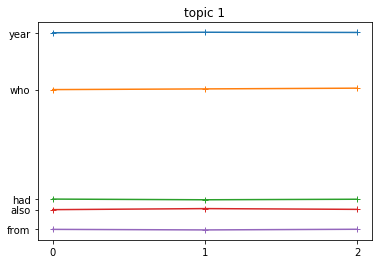

In [69]:
# various ways to visualize the output
import matplotlib.pyplot as plt 
from gensim import matutils

# 1. print out the words distribution for each topic, given any time slice. By looking at the keywords you can interpret the actual topic
ldaseq.print_topics(time=0, top_terms=5)

# 2. print out words distribution for a given topic at different time slices
ldaseq.print_topic_times(topic=0,top_terms=5) # evolution of 1st topic

# 3. get the word frequency change under one topic (the plot in our proposal) -- zw, 11/23
# pick a topic
whichtopic = 0
# pick the top 5 words at time 0
wordtime = 0
# trace these words' frequency within the topic
npick=5
topicP = ldaseq.topic_chains[whichtopic].e_log_prob
topicP = np.transpose(topicP)
wordids = matutils.argsort(topicP[wordtime], npick, reverse=True)

wfreqs = np.empty((len(time_slice),npick))
for kt in range(len(time_slice)):
    topic = np.exp(topicP[kt])
    topic = topic/sum(topic)
    
    wfreqs[kt] = np.array([topic[id_] for id_ in wordids])


plt.plot(wfreqs,'-+')
plt.yticks(wfreqs[0],[ldaseq.id2word[id_] for id_ in wordids])
plt.xticks(np.arange(len(time_slice)))
plt.title('topic %d'%(whichtopic+1))
plt.show()



In [49]:
[ldaseq.id2word[id_] for id_ in wordids]

['asrc', 'management', 'technology']

In [10]:
# Visualizing topic model given a time point (i.e. not dynamic)
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis

doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)

# For ipython notebook:
pyLDAvis.display(vis_dtm)

# This works best for me (then view dtm.html in a browser)
with open("dtm1.html", "w") as f:
    pyLDAvis.save_html(vis_dtm, f)

/Users/zhiwei/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [11]:
pyLDAvis.display(vis_dtm)
